# Import libraries and setup constants

In [46]:
import json
import geojson

import matplotlib.pyplot as plt

from shapely.geometry import shape, Polygon, MultiPolygon
from shapely.strtree import STRtree
import networkx as nx
from networkx.readwrite import json_graph

from seawulf_constants import *

abbreviation_to_name = {
    "MD" : "maryland",
    "SC" : "south_carolina"
}

# Toggle to control which state you generate the graph for when you run these code blocks
CHOSEN_STATE_TO_BE_GENERATED = "SC"
STATE_NAME = abbreviation_to_name[CHOSEN_STATE_TO_BE_GENERATED]

#  Create the dual graph of the precincts using neighbor lists

In [48]:
precincts_geojson_file = (STATES_FOLDER + STATE_NAME + GEODATA_FOLDER + STATE_NAME + PRECINCTS_FILEPATH + GEOJSON_FILE_EXTENSION)
#precincts_geojson_file = ("../processed_individual/fixed_geojson/maryland_precincts_fixed.geojson")
with open(precincts_geojson_file, 'r') as f:
    precincts_geojson_data = json.load(f)

precincts_dual_graph = nx.Graph()

precincts = []
for feature in precincts_geojson_data['features']:
    unique_precinct_id = feature['properties'][UNIQUE_ID_LABEL]
    precinct_geometry = shape(feature['geometry'])
    precinct_centroid_point = precinct_geometry.centroid
    precincts.append((unique_precinct_id, precinct_geometry, precinct_centroid_point))
    centroid_longitude = precinct_centroid_point.x
    centroid_latitude = precinct_centroid_point.y
    precincts_dual_graph.add_node(unique_precinct_id, center_point_longitude=centroid_longitude, center_point_latitude=centroid_latitude)

buffered_precinct_geometries = {}
for unique_precinct_id, precinct_geometry, _ in precincts:
   buffered_precinct_geometry = precinct_geometry.buffer(distance=DEGREES_OF_LATITUDE_LONGITUDE_FOR_200_FEET)
   buffered_precinct_geometries[unique_precinct_id] = buffered_precinct_geometry
   
buffered_precinct_geometries_for_tree = list(buffered_precinct_geometries.values())
precinct_geometry_str_tree = STRtree(buffered_precinct_geometries_for_tree)

index_to_precinct_id = {i: unique_precinct_id for i, (unique_precinct_id, _, _) in enumerate(precincts)}

for unique_precinct_id, precinct_geometry, _ in precincts:
    potential_neighboring_precincts = precinct_geometry_str_tree.query(precinct_geometry)
    for precinct_neighbor_index in potential_neighboring_precincts:
        neighbor_precinct_id = index_to_precinct_id[precinct_neighbor_index]
        neighbor_precinct_geometry = buffered_precinct_geometries[neighbor_precinct_id]
        if unique_precinct_id != neighbor_precinct_id and precinct_geometry.intersects(neighbor_precinct_geometry):
            intersection = precinct_geometry.intersection(neighbor_precinct_geometry)
            boundary = intersection.boundary
            if boundary is None:
                continue
            elif boundary.length >= DEGREES_OF_LATITUDE_LONGITUDE_FOR_200_FEET:
                precincts_dual_graph.add_edge(unique_precinct_id, neighbor_precinct_id)

graph_positions = {node: (data['center_point_longitude'], data['center_point_latitude']) for node, data in precincts_dual_graph.nodes(data=True)}
graph_json = json_graph.node_link_data(precincts_dual_graph)
output_file_name = PRECINCTS_GRAPH_FILEPATH_START + CHOSEN_STATE_TO_BE_GENERATED + ".json"
with open(output_file_name, "w") as f:
    json.dump(graph_json, f, indent=4)

#  Visual plot display of generated precinct graphs

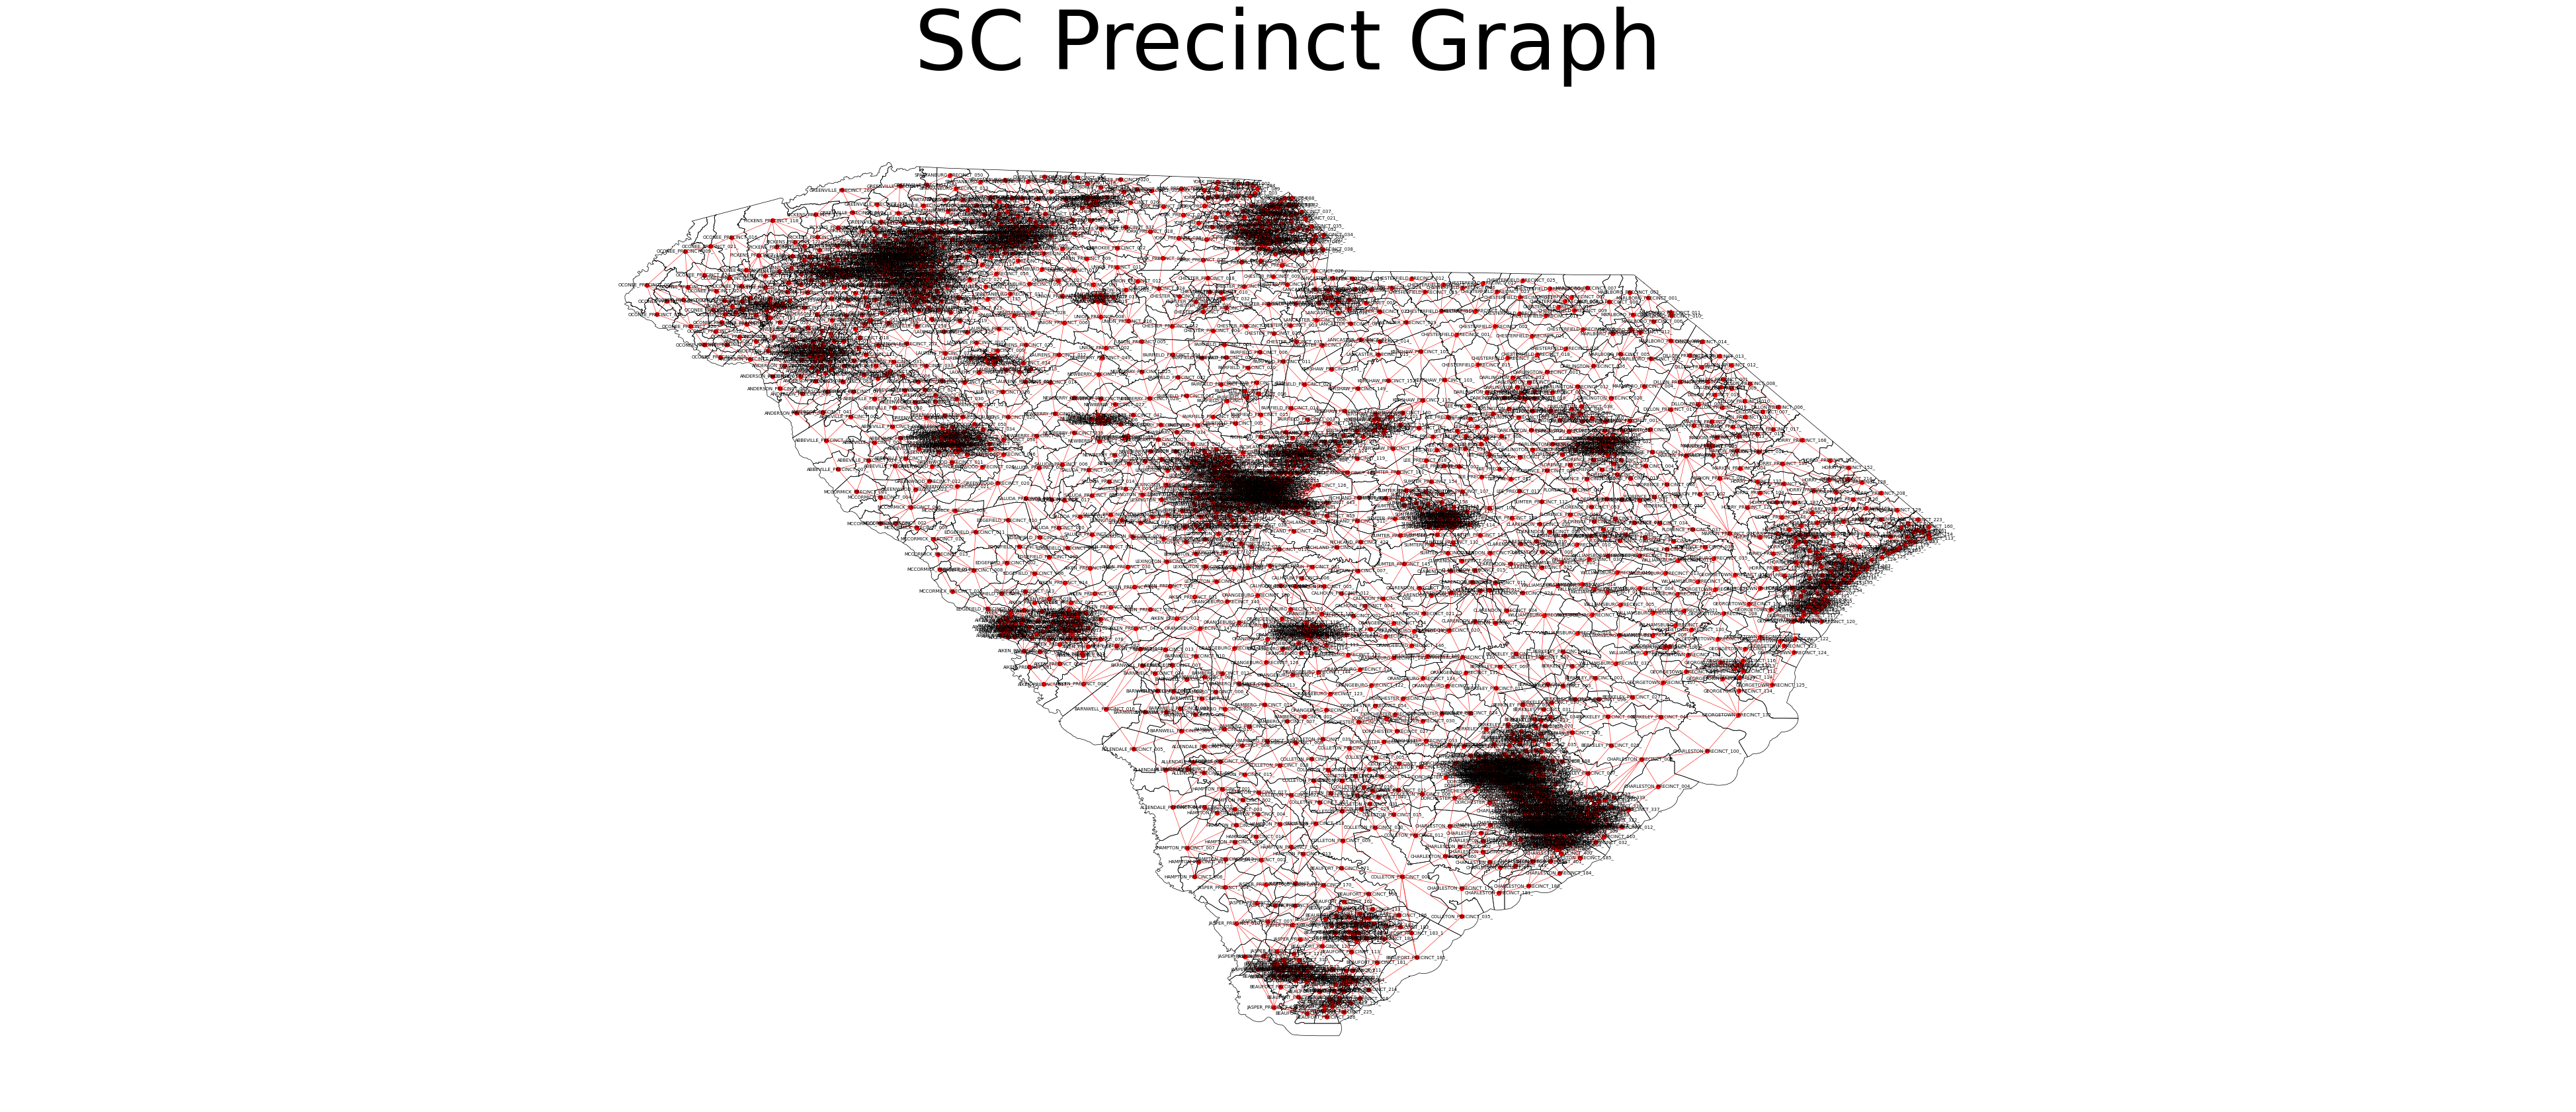

In [50]:
# Visual plot display params
PLOT_TITLE = (CHOSEN_STATE_TO_BE_GENERATED + " Precinct Graph")

DRAW_PRECINCT_NODES_AND_EDGES = True
NODE_COLOR = "red"
NODE_SIZE = 18
EDGE_COLOR = "red"
EDGE_WIDTH = 0.4
OUTPUT_WITH_NODE_LABELS = True
NODE_LABELS_FONT_SIZE = 5

DRAW_PRECINCT_GEOMETRY = True
PRECINCT_GEOMETRY_COLOR = "black"
PRECINCT_GEOMETRY_LINE_WIDTH = 0.5

graph_json_file_name = PRECINCTS_GRAPH_FILEPATH_START + CHOSEN_STATE_TO_BE_GENERATED + ".json"

with open(graph_json_file_name, "r") as f:
    graph_data = json.load(f)

precinct_graph = json_graph.node_link_graph(graph_data)

fig, ax = plt.subplots(figsize=(50,20))
if DRAW_PRECINCT_GEOMETRY:
    for unique_precinct_id, geometry, _ in precincts:
        if isinstance(geometry, Polygon):
            x, y = geometry.exterior.xy  
            ax.plot(x, y, color=PRECINCT_GEOMETRY_COLOR, linewidth=PRECINCT_GEOMETRY_LINE_WIDTH)
        elif isinstance(geometry, MultiPolygon):
            for polygon in geometry.geoms:
                x, y = polygon.exterior.xy
                ax.plot(x, y, color=PRECINCT_GEOMETRY_COLOR, linewidth=PRECINCT_GEOMETRY_LINE_WIDTH)
if DRAW_PRECINCT_NODES_AND_EDGES:
    nx.draw(
        precinct_graph,
        pos=graph_positions,
        ax=ax,
        with_labels=OUTPUT_WITH_NODE_LABELS,
        node_size=NODE_SIZE,
        node_color=NODE_COLOR,
        font_size=NODE_LABELS_FONT_SIZE,
        edge_color=EDGE_COLOR,
        width=EDGE_WIDTH
    )
ax.set_aspect('equal', adjustable='datalim')
plot_label = PLOT_TITLE
plt.title(label=plot_label, fontsize=90)
plt.title
plt.show()

#  Adding additional data for precinct graph nodes

In [52]:
output_file_path = PRECINCTS_GRAPH_FILEPATH_START + CHOSEN_STATE_TO_BE_GENERATED + "_output_for_seawulf.json"

# A precinct graph file must be manually renamed to include "_input", this forces us to choose exactly which graph file to use as input to this code block
precincts_graph_file_path = PRECINCTS_GRAPH_FILEPATH_START + CHOSEN_STATE_TO_BE_GENERATED + "_input.json"

precincts_geojson_file_path = STATES_FOLDER + STATE_NAME + GEODATA_FOLDER + STATE_NAME + PRECINCTS_FILEPATH + GEOJSON_FILE_EXTENSION

precincts_demographic_file_path = STATES_FOLDER + STATE_NAME + DEMOGRAPHIC_FOLDER + STATE_NAME + PRECINCTS_DEMOGRAPHIC_FILEPATH + JSON_FILE_EXTENSION
precincts_economic_file_path = STATES_FOLDER + STATE_NAME + ECONOMIC_FOLDER + STATE_NAME + PRECINCTS_ECONOMIC_FILEPATH + JSON_FILE_EXTENSION
precincts_election_file_path = STATES_FOLDER + STATE_NAME + ELECTION_FOLDER + CHOSEN_STATE_TO_BE_GENERATED + PRECINCTS_ELECTION_FILEPATH + JSON_FILE_EXTENSION
# precincts_election_file_path = "md_gov_fix.json"
precincts_region_type_file_path = STATES_FOLDER + STATE_NAME + GEODATA_FOLDER + STATE_NAME + PRECINCTS_GEOJSON_REGION_TYPE_FILEPATH + JSON_FILE_EXTENSION

with open(precincts_graph_file_path) as precinct_graph_file:
  precinct_graph_json = json.load(precinct_graph_file)
precinct_graph = json_graph.node_link_graph(precinct_graph_json)

with open(precincts_geojson_file_path) as precinct_data_file:
  precinct_data_geojson = geojson.load(precinct_data_file)

with open(precincts_demographic_file_path) as demographic_data_file:
  precinct_demographic_data_json = json.load(demographic_data_file)

with open(precincts_economic_file_path) as economic_data_file:
  precinct_economic_data_json = json.load(economic_data_file)

with open(precincts_election_file_path) as election_data_file:
  precinct_election_data_json = json.load(election_data_file)

with open(precincts_region_type_file_path) as region_data_file:
  precinct_region_data_json = json.load(region_data_file)

precinct_region_type = {}
total_pop_2022 = {}
white_pop_2022 = {}
black_pop_2022 = {}
asian_pop_2022 = {}
hispanic_pop_2022 = {}
congressional_districts_2022 = {}
total_households = {}
average_household_incomes = {}
votes_for_gov_total = {}
votes_democratic = {}
votes_republican = {}

precinct_features = precinct_data_geojson['features']
for precinct in precinct_features:
  precinct_properties = precinct.get('properties', {})
  congressional_districts_2022[precinct_properties.get(UNIQUE_ID_LABEL)] = precinct_properties.get("CONG_DIST")

for precinct in precinct_demographic_data_json:
  precinct_id = precinct[UNIQUE_ID_LABEL]
  total_pop_2022[precinct_id] = precinct[TOTAL_POP_LABEL]
  white_pop_2022[precinct_id] = precinct[WHITE_POP_LABEL]
  black_pop_2022[precinct_id] = precinct[BLACK_POP_LABEL]
  asian_pop_2022[precinct_id] = precinct[ASIAN_POP_LABEL]
  hispanic_pop_2022[precinct_id] = precinct[HISPANIC_POP_LABEL]

for precinct in precinct_economic_data_json:
  precinct_id = precinct[UNIQUE_ID_LABEL]
  # Calculate precinct's avg household income
  total_households_value = precinct[TOTAL_HOUSEHOLDS_LABEL]
  total_households[precinct_id] = total_households_value
  eco_0K_35K = precinct[ECO_0K_35K_LABEL]
  eco_35K_60K = precinct[ECO_35K_60K_LABEL]
  eco_60K_100K = precinct[ECO_60K_100K_LABEL]
  eco_100K_125K = precinct[ECO_100K_125K_LABEL]
  eco_125K_150K = precinct[ECO_125K_150K_LABEL]
  eco_150K_MORE = precinct[ECO_150K_MORE_LABEL]
  calculated_average_household_income_total = (17499 * eco_0K_35K) + (47499 * eco_35K_60K) + (79999 * eco_60K_100K) + (112499 * eco_100K_125K) + (137499 * eco_125K_150K) + (150000 * eco_150K_MORE)
  calculated_average_household_income = None
  if total_households_value <= 0:
    calculated_average_household_income = 0
  else:
    calculated_average_household_income = round(calculated_average_household_income_total / total_households_value)
  average_household_incomes[precinct_id] = calculated_average_household_income

for precinct in precinct_election_data_json:
  precinct_id = precinct[UNIQUE_ID_LABEL]
  votes_for_gov_total[precinct_id] = precinct[TOTAL_GOV_VOTES_LABEL]
  votes_democratic[precinct_id] = precinct[TOTAL_DEM_VOTES_LABEL]
  votes_republican[precinct_id] = precinct[TOTAL_REP_VOTES_LABEL]

for precinct in precinct_region_data_json:
  precinct_id = precinct[UNIQUE_ID_LABEL]
  precinct_region_type[precinct_id] = precinct[REGION_TYPE_LABEL]

for node, data in precinct_graph.nodes(data=True):
  data[DISTRICTS_LABEL] = congressional_districts_2022[node]
  data[REGION_TYPE_LABEL] = precinct_region_type[node]
  data[TOTAL_POP_LABEL] = total_pop_2022[node]
  data[WHITE_POP_LABEL] = white_pop_2022[node]
  data[BLACK_POP_LABEL] = black_pop_2022[node]
  data[ASIAN_POP_LABEL] = asian_pop_2022[node]
  data[HISPANIC_POP_LABEL] = hispanic_pop_2022[node]
  data[AVG_HOUSEHOLD_INCOME_LABEL] = average_household_incomes[node]
  data[TOTAL_HOUSEHOLDS_LABEL] = total_households[node]
  data[TOTAL_GOV_VOTES_LABEL] = votes_for_gov_total[node]
  data[TOTAL_DEM_VOTES_LABEL] = votes_democratic[node]
  data[TOTAL_REP_VOTES_LABEL] = votes_republican[node]

updated_graph_data = json_graph.node_link_data(precinct_graph)
with open(output_file_path, "w") as f:
    json.dump(updated_graph_data, f, indent=4)

In [39]:


votes_for_gov_totala = {}
votes_democratica = {}
votes_republicana = {}

for precinct in precinct_demographic_data_json:
  precinct_ida = precinct[UNIQUE_ID_LABEL]
  # precinct_election_data_json
  if any(election_precinct[UNIQUE_ID_LABEL] == precinct_ida for election_precinct in precinct_election_data_json):
    continue
  else:
    votes_for_gov_totala[precinct_ida] = 0

for precinct in votes_for_gov_totala:
    new_entry = {
        "UNIQUE_ID": precinct,  # Use the key from votes_for_gov_totala
        "TOT_VOT": 0,
        "TOT_DEM": 0,
        "TOT_REP": 0,
        "LEAN": "Unknown"
    }
    # Append the new entry to the election data
    precinct_election_data_json.append(new_entry)

with open("md_gov_fix.json", 'w') as json_filea:
    json.dump(precinct_election_data_json, json_filea, indent=4)